In [1]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil



---

### Conversão de site - Teste A/B

Um teste A/B é uma técnica de experimentação que compara duas versões de uma variável para determinar qual delas performa melhor. Vamos realizar um teste A/B para avaliar um novo design de um ecommerce. Esse teste envolve a criação de duas versões do site: a versão atual (A) e a nova versão (B). Metade dos visitantes será direcionada para a versão A e a outra metade para a versão B. Durante o período do teste, coletaremos dados sobre o comportamento dos usuários em ambas as versões, especialmente focando na taxa de conversão, que é a porcentagem de visitantes que realizam uma compra.

A meta de negócio é aumentar a taxa de conversão em 21%. Isso significa que esperamos que a nova versão do design (B) leve a um aumento significativo no número de clientes que fazem uma compra em comparação com a versão atual (A).

Ao final do teste, analisaremos os dados coletados para determinar se o novo design realmente melhora a taxa de conversão e, consequentemente, contribui para o crescimento das vendas no ecommerce. Se os resultados mostrarem um aumento significativo na conversão com o design B, esse será adotado como o novo padrão para o site.


# 1) Escolha sua métrica e meça o estado atual do processo

Dado que não sabemos se o novo design terá um desempenho melhor ou pior (ou igual?) que nosso design atual, escolheremos um teste bilateral:

Hₒ: p = pₒ

Hₐ: p ≠ pₒ

onde p e pₒ representam a taxa de conversão do projeto novo e antigo, respectivamente.

Também definiremos um nível de confiança de 95%

## Escolhendo as variáveis
Para nosso teste, precisaremos de dois grupos:

Um grupo de controle - Eles verão o design antigo

Um grupo de tratamento (ou experimental) - Eles verão o novo design

A razão pela qual temos dois grupos, embora conheçamos a taxa de conversão da linha de base, é que queremos controlar outras variáveis ​​que possam afetar nossos resultados: tendo um grupo de controle, podemos comparar diretamente seus resultados com o grupo de tratamento, porque o a única diferença sistemática entre os grupos é o design da página de destino e, portanto, podemos atribuir quaisquer diferenças nos resultados aos designs.

Para nossa variável dependente (ou seja, o que estamos tentando medir), estamos interessados ​​em capturar a taxa de conversão. Uma maneira de codificar isso é por cada sessão de usuário com uma variável binária:

0 - O usuário não comprou o produto durante esta sessão de usuário

1 - O usuário comprou o produto durante esta sessão de usuário

In [2]:
df_anterior = pd.read_csv("../data/df_anterior.csv")

In [3]:
df_anterior

,Unnamed: 0,user_id,timestamp,converted
0,4402,759903,2017-01-21 20:33:04.550046,0
1,214023,889087,2017-01-16 16:59:09.713050,0
2,143767,896579,2017-01-10 03:04:35.928212,0
3,192434,748209,2017-01-23 22:31:58.061727,0
4,139934,935283,2017-01-07 18:17:28.683289,0
...,...,...,...,...
29435,260051,818732,2017-01-17 20:12:58.845647,0
29436,284977,652954,2017-01-22 18:12:06.306757,0
29437,257905,844938,2017-01-20 17:35:14.574455,1
29438,40693,851118,2017-01-10 21:26:08.198578,0


In [4]:
# Calcula a taxa de conversão atual

# Filtra o DataFrame 'df_anterior' para obter apenas as linhas onde a coluna 'converted' é igual a 1
# Em outras palavras, obtém apenas os usuários que foram convertidos
usuarios_convertidos = df_anterior[df_anterior.converted == 1]

# Conta o número de usuários convertidos, considerando a coluna 'user_id'
contagem_usuarios_convertidos = usuarios_convertidos.user_id.count()

# Conta o número total de usuários no DataFrame 'df_anterior', considerando a coluna 'user_id'
contagem_total_usuarios = df_anterior.user_id.count()

# Calcula a taxa de conversão dividindo o número de usuários convertidos pelo número total de usuários
conversao_atual = contagem_usuarios_convertidos / contagem_total_usuarios

# Arredonda a taxa de conversão para três casas decimais
conversao_atual_arredondada = round(conversao_atual, 3)

# Exibe a taxa de conversão arredondada
conversao_atual_arredondada


np.float64(0.122)

In [5]:
# Para atingir a meta, precisamos aumentar a conversão em 20%

# Calcula a nova taxa de conversão necessária para atingir a meta
# A meta é aumentar a conversão atual em 21% (20% de aumento + 1% para manter a conversão atual)
meta = conversao_atual * 1.21

# Arredonda a nova taxa de conversão para três casas decimais
meta_arredondada = round(meta, 3)

# Exibe a nova taxa de conversão arredondada
meta_arredondada


np.float64(0.148)

### Desvio padrão de distribuições binomiais

## Conceitos

### Desvio Padrão de Distribuições Binomiais

O desvio padrão é uma medida que mostra o quanto os resultados de uma série de experimentos variam em relação à média.

#### Distribuição Binomial

Imagine que você está jogando uma moeda várias vezes e quer saber quantas vezes ela cai em "cara". A distribuição binomial nos ajuda a entender a probabilidade de obter um certo número de "caras" em um número fixo de jogadas.

#### Média

A média é o valor que você esperaria obter, em média, se repetisse o experimento muitas vezes. No caso de jogar uma moeda 100 vezes, você esperaria obter "cara" cerca de 50 vezes se a moeda for justa.

#### Desvio Padrão

O desvio padrão nos diz o quanto os resultados (quantas vezes deu "cara") variam em torno dessa média.

- Se o desvio padrão é pequeno, significa que a maioria dos resultados está bem próxima da média.
- Se o desvio padrão é grande, significa que os resultados estão mais espalhados e podem variar bastante da média.

Para uma moeda justa jogada 100 vezes, se a média esperada é 50 "caras", um desvio padrão pequeno pode nos mostrar que na maioria das vezes você obterá algo como 48, 49, 50, 51 ou 52 "caras". Um desvio padrão grande indicaria que você poderia obter valores muito diferentes, como 40 ou 60 "caras" com mais frequência.


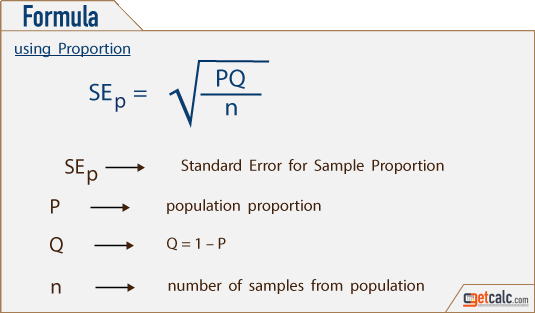

In [6]:
#desvio padrao atual
std_atual = ((conversao_atual*(1-conversao_atual))/df_anterior.user_id.count())**0.5
std_atual

np.float64(0.0019091448173320464)

In [7]:
df_anterior.shape

(29440, 4)

# 2) Calcule o tamanho mínimo da amostra necessária
É importante observar que, como não testaremos toda a base de usuários (nossa população) pois queremos testar uma amostra antes de aplicarmos para todos os nossos usuários e comprovar a efetividade.

O número de pessoas (ou sessões de usuários na página) que decidirmos capturar em cada grupo afetará a precisão de nossas taxas de conversão estimadas: quanto maior o tamanho da amostra, mais precisas nossas estimativas.

Por outro lado, quanto maior nossa amostra, mais caro (e impraticável) nosso estudo se torna.
Então, quantas pessoas devemos ter em cada grupo?

**G*POWER**



# 3) Separe grupo controle e grupo experimental e colete os resultados

Agora que temos o tamanho mínimo de amostras, selecionamos alguns usuários frequentes para serem nosso grupo de teste e o nosso grupo experimental.

Para a seleção de usuários, importante ressaltar:

- Intragrupos: devemos ter clientes variados que representem bem a nossa população
- Intergrupos: os clientes do grupo teste precisam ser comparáveis com o grupo controle para evitar qualquer tipo de viés de seleção

Supondo que tivemos todos esses cuidados, rodamos o teste e temos o seguinte dataset:

In [8]:
df_test = pd.read_csv("../data/df_test.csv")
df_test

#2818

,Unnamed: 0,user_id,timestamp,landing_page,converted,group
0,281655,918193,2017-01-03 13:42:27.285433,new_page,1,treatment
1,7271,679658,2017-01-20 02:00:54.448676,new_page,1,treatment
2,269760,815158,2017-01-16 05:11:33.823264,new_page,1,treatment
3,158882,857307,2017-01-22 08:58:50.687626,new_page,1,treatment
4,153958,716896,2017-01-15 17:59:03.065352,new_page,1,treatment
...,...,...,...,...,...,...
5631,2813,848867,2017-01-03 04:37:58.815088,old_page,0,control
5632,2814,896519,2017-01-05 18:54:30.314378,old_page,0,control
5633,2815,639731,2017-01-23 10:15:31.261524,old_page,0,control
5634,2816,788990,2017-01-10 12:51:44.488371,old_page,0,control


# 4. Comprove a partir dos testes de hipótese se houve mudança

Agora chegou a hora de usarmos nossos conhecimentos de teste de hipótese para comprovar diferenças de média!

In [9]:
grupo_tratamento = df_test[df_test.group == "treatment"]
grupo_controle = df_test[df_test.group == "control"]

conversao_tratamento = grupo_tratamento[grupo_tratamento.converted==1].user_id.count()/grupo_tratamento.user_id.count()

conversao_controle = grupo_controle[grupo_controle.converted==1].user_id.count()/grupo_controle.user_id.count()

print(conversao_tratamento, conversao_controle)

0.18985095812633074 0.12455642299503193


Vimos aqui que, aparentemente, houve melhora na média. Mas será que é estatisticamente significativo?

A depender do que você tem em sua amostra, escolhemos o teste a ser usado. Aqui estamos falando de uma proporção (conversão é a proporção) e, portanto, vamos usar o teste de comparação de proporções.

### Teste de Comparação de Proporções

Quando queremos comparar duas proporções para ver se são significativamente diferentes, usamos o teste de comparação de proporções. Este teste é útil quando estamos lidando com dados categóricos, como a taxa de conversão (a proporção de usuários que realizaram uma ação desejada).

#### O que é uma Proporção?

Uma proporção é uma parte de um todo expressa como uma fração, decimal ou porcentagem. Por exemplo, se 20 de 100 usuários de um site compram um produto, a proporção de conversão é 20/100 ou 0.20 (20%).

#### Quando Usar o Teste de Comparação de Proporções?

Usamos o teste de comparação de proporções quando queremos comparar duas proporções para ver se a diferença entre elas é estatisticamente significativa. Por exemplo, se queremos saber se a taxa de conversão de um novo design de site é diferente da taxa de conversão do design atual.

#### Como Funciona o Teste?

1. **Formule as Hipóteses**:
   - **Hipótese Nula (H_0)**: As proporções são iguais (não há diferença significativa).
   - **Hipótese Alternativa (H_a)**: As proporções são diferentes (há uma diferença significativa).

2. **Calcule as Proporções**:
   - p_1: Proporção do primeiro grupo (por exemplo, taxa de conversão do site atual).
   - p_2: Proporção do segundo grupo (por exemplo, taxa de conversão do novo design).

3. **Calcule a Estatística do Teste**:
   - Use a fórmula do teste z para proporções, que leva em consideração as proporções dos dois grupos e o tamanho das amostras.

4. **Determine o Valor-p**:
   - O valor-p nos diz a probabilidade de observarmos uma diferença tão grande (ou maior) entre as proporções, assumindo que a hipótese nula é verdadeira.

5. **Compare com o Nível de Significância (alpha)**:
   - Se o valor-p for menor que (alpha) (por exemplo, 0.05), rejeitamos a hipótese nula, indicando que há uma diferença significativa entre as proporções.



In [10]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint


control_results = grupo_controle['converted'] #=grupo_controle[grupo_controle.converted==1].user_id.count()
treatment_results = grupo_tratamento['converted'] #=grupo_tratamento[grupo_tratamento.converted==1].user_id.count()


successes = [control_results.sum(), treatment_results.sum()] #quantos valores sucesso tivemos em cada grupo, ou seja, quantos 1 tivemos em cada grupo

n_con = grupo_controle.user_id.count()
n_treat = grupo_tratamento.user_id.count()

nobs = [n_con, n_treat] #tamanho das amostras de cada grupo

proportions_ztest(successes, nobs=nobs) #calculamos z para o teste e seu respectivo pvalor



(np.float64(-6.733481162342496), np.float64(1.6565111652777357e-11))

Nosso teste era bilateral, com 95% de confiança.
Lembrando que para esse caso, a zona de rejeição é z<-1.96 e z>1.96.
Logo, para z=-6.73 REJEITAMOS a hipótese nula. Ou seja, as proporções não são iguais

Podemos rejeitar também pelo valor menor que 0.05 do pvalue

Podemos ver também como fica o intervalo de confiança e tirar insights sobre isso

In [11]:
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)


print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

ci 95% for control group: [0.112, 0.137]
ci 95% for treatment group: [0.175, 0.204]



# Sumário

#### Carregar e Examinar Dados

1. **Ler um arquivo CSV:**
   ```python
   df = pd.read_csv("nome_do_arquivo.csv")
   ```

2. **Verificar tamanho do DataFrame (linhas x colunas):**
   ```python
   df.shape
   ```

3. **Verificar o tipo de cada coluna:**
   ```python
   df.info()
   ```

4. **Verificar o nome das colunas do DataFrame:**
   ```python
   df.columns
   ```

5. **Exibir principais estatísticas:**
   ```python
   df.describe()
   ```

#### Verificar e Manipular Dados

6. **Verificar a soma total de duplicados de cada coluna:**
   ```python
   df.duplicated().sum()
   ```

7. **Exibir o tipo de dados e retornar o nome da coluna:**
   ```python
   df.select_dtypes(include=lista_tipos_dados).columns
   ```

8. **Usar a função where para encontrar os valores nulos e substituí-los:**
   ```python
   np.where(df[nome_coluna].isnull(), 0, 1)
   ```

#### Análise Estatística

9. **Cálculo do Desvio Padrão:**
   ```python
   df["nome_coluna"].std()
   ```

10. **Cálculo da Variância:**
    ```python
    df["nome_coluna"].var()
    ```

11. **Cálculo do Coeficiente de Variação:**
    ```python
    df["Income"].std() / df["Income"].mean()
    ```

12. **Cálculo do Skewness (Assimetria):**
    ```python
    df["nome_coluna"].skew()
    ```

13. **Usar o groupby para agrupar os dados de acordo com a coluna_1:**
    ```python
    df.groupby(["coluna_1"])
    ```

14. **Teste T:**
    ```python
    from scipy import stats
    t_stat, p_value = stats.ttest_ind(df["coluna1"], df["coluna2"])
    ```

15. **Teste F:**
    ```python
    f_stat, p_value = stats.f_oneway(df["coluna1"], df["coluna2"])
    ```

16. **Teste de Bartlett:**
    ```python
    bartlett_stat, p_value = stats.bartlett(df["coluna1"], df["coluna2"])
    ```

17. **ANOVA de Welch:**
    ```python
    welch_stat, p_value = stats.ttest_ind(df["coluna1"], df["coluna2"], equal_var=False)
    ```

18. **Teste Não Paramétrico Games-Howell:**
    ```python
    import pingouin as pg
    pg.pairwise_gameshowell(dv='SalePrice', between='MSZoning', data=df)
    ```

19. **Teste de Kolmogorov-Smirnov (KS) para Normalidade:**
    ```python
    from scipy.stats import kstest
    ks_statistic, p_value = kstest(df["nome_coluna"], 'norm')
    ```

20. **Teste Mann-Whitney U:**
    ```python
    from scipy.stats import mannwhitneyu
    u_statistic, p_value = mannwhitneyu(df["coluna1"], df["coluna2"], alternative='two-sided')
    ```

21. **Teste Z para Proporções:**
    ```python
    from statsmodels.stats.proportion import proportions_ztest

    count = np.array([soma_sucessos_grupo1, soma_sucessos_grupo2])
    nobs = np.array([total_observacoes_grupo1, total_observacoes_grupo2])
    stat, p_value = proportions_ztest(count, nobs)
    ```

22. **Intervalo de Confiança para Proporções:**
    ```python
    from statsmodels.stats.proportion import proportion_confint

    confint_1 = proportion_confint(soma_sucessos_grupo1, total_observacoes_grupo1, alpha=0.05, method='normal')
    confint_2 = proportion_confint(soma_sucessos_grupo2, total_observacoes_grupo2, alpha=0.05, method='normal')
    ```

#### Visualização de Dados

23. **Plotar Histograma:**
    ```python
    df['nome_coluna'].hist()
    ```

24. **Plotar Boxplot:**
    ```python
    sns.boxplot(df["nome_coluna"])
    ```

25. **Plotar Gráfico de Dispersão:**
    ```python
    plt.scatter(df["coluna1"], df["coluna2"])
    plt.show()
    ```